![IronHack Logo](https://s3-eu-west-1.amazonaws.com/ih-materials/uploads/upload_d5c5793015fec3be28a63c4fa3dd4d55.png)

# Web Project

### Comparativa de precios de criptoactivos entre datos obtenidos del exchange Bitstamp (API) y la plataforma de P2P LocalBitcoins (Scraping)

#### by Octavio Garcia (Data Analytics Bootcamp 2019)

## Alcance
En el presente proyecto se realiza un ejercicio académico de extracción de datos utilizando 2 técnicas diferentes, con el objetivo de relacionar dichos datos enriqueciendo así el dataset.
- **Obtención de datos mediante API REST**. Se han obtenido más de 5.000 registros correspondientes a las transacciones realizadas en 1 día del par BTC-EUR dentro del exchange Bitstamp (https://www.bitstamp.net/api/). Dichos datos han sido tratados con el objetivo de determinar la tendencia del precio del BTC en EUROS durante un periodo de 24 horas.
- **Obtención de datos mediante WEB SCRAPING**. Se han obtenido 500 registros correspondientes a las ofertas publicadas en el portal de permutas P2P Local Bitcoins. En dicho portal los usuarios registrados ofrecen pequeñas cantidades de BTC a otros usuarios. Esta plataforma es ampliamente utilizada en regiones con problemas importantes de devaluación monetaria. No obstante, para efectos de este proyecto, se ha limitado la adquisición de datos a las ofertas realizadas en EUROS. Cabe indicar que la plataforma posee una API (https://localbitcoins.com//buy-bitcoins-online/EUR/.json), sin embargo esta solo permite una extracción limitada de las ofertas en EUROS (hasta 50 ofertas). 

**NOTA IMPORTANTE:** todos los datos extraidos corresponden a las transacciones de las últimas 24 y las ofertas publicadas en un día concreto respectivamente. Por tanto, se trata de una relación BTC-EURx24H. Sin embargo, esa relación temporal no puede establecerse de forma rigurosa dentro del periodo señalado ya que los registros de transacciones representan una serie de tiempo a lo largo de un período de 24 horas mientras que las ofertas, aunque están ordenadas de forma cronológica, van desapareciendo del listado según se van cerrando las operaciones. Por lo tanto se ha optación por realizar un análisis pseudo-estadístico con la intención de establecer con la comparativa un "máximo" razonable de aceptación de una oferta P2P en función de la evolución de precios en el exchange.

### Importación de módulos

In [1]:
#Se importan los módulos necesarios para todas las operaciones realizadas en el proyecto.
import json
import requests
import numpy as np
import pandas as pd
#Web scraping
from bs4 import BeautifulSoup
import re
#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

### API Rest

In [2]:
#Extracción de datos desde API Rest: transacciones de las últimas 24h (.json).
source = "https://www.bitstamp.net/api/v2/transactions/btceur/?time=day"
exchangeTrans = requests.get(source)
json_exchangeTrans = exchangeTrans.json()

In [3]:
#Creación del DataFrame, definición de columnas y eliminación de columnas que no se utilizarán en el proyecto.
col_clean = ['amount','tid','type']
crypto_ex = pd.DataFrame(json_exchangeTrans).drop(col_clean, axis=1).rename(index=int, columns={"date":"UnixTime",
                                                                                               "price":"Exchange"})
display(crypto_ex.dtypes,crypto_ex.head())

UnixTime    object
Exchange    object
dtype: object

,UnixTime,Exchange
0,1549929391,3192.28
1,1549929383,3192.28
2,1549929382,3192.28
3,1549929354,3192.28
4,1549929340,3192.27


In [4]:
#Transformación de los tipos de datos a valores numéricos.
col_type = ['UnixTime','Exchange']
crypto_ex[col_type] = crypto_ex[col_type].apply(pd.to_numeric, errors='coerce')
display(crypto_ex.dtypes,crypto_ex.head(),len(crypto_ex))

UnixTime      int64
Exchange    float64
dtype: object

,UnixTime,Exchange
0,1549929391,3192.28
1,1549929383,3192.28
2,1549929382,3192.28
3,1549929354,3192.28
4,1549929340,3192.27


5294

In [5]:
#Se guarda fichero .csv en output con los datos "en bruto".
crypto_ex.to_csv('./output/crypto_ex.csv', index=False, encoding = 'utf-8')

In [6]:
#Se eliminan valores repetidos tanto de precio ('Exchange') como de tiempo ('UnixTime').
crypto_ex1 = crypto_ex.drop_duplicates(subset='Exchange', keep="last").sort_index()
crypto_ex2 = crypto_ex1.drop_duplicates(subset='UnixTime', keep="last").sort_index().reset_index().drop(['index','UnixTime'],axis=1)
#Se elimina columna 'UnixTime' para efectos de visualización.
display(crypto_ex2.head(),len(crypto_ex2))
#NOTA: el valor en el index=0 es el valor más reciente en el tiempo.

,Exchange
0,3192.25
1,3192.28
2,3192.39
3,3192.31
4,3192.37


1523

In [7]:
#Se generan valores estadisticos del nuevo DataFrame.
stats_ex = crypto_ex2.describe().transpose()
stats_ex['IQR'] = stats_ex['75%'] - stats_ex['25%']
display(stats_ex)

,count,mean,std,min,25%,50%,75%,max,IQR
Exchange,1523.0,3189.1265,9.551814,3168.58,3180.785,3190.47,3196.315,3228.12,15.53


In [8]:
#Se calcula el porcentaje de outliers
out_ex = pd.DataFrame(columns=crypto_ex2.columns)
for col in stats_ex.index:
    iqr = stats_ex.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats_ex.at[col,'25%'] - cutoff
    upper = stats_ex.at[col,'75%'] + cutoff
    results = crypto_ex2[(crypto_ex2[col] < lower) | 
                   (crypto_ex2[col] > upper)].copy()
    out_ex = out_ex.append(results)
print('El porcentaje de outliers es de:',"{0:.2f}".format(len(out_ex)/len(crypto_ex2)*100),'%')

El porcentaje de outliers es de: 0.53 %


y=-0.000224x+(3198.790697) 



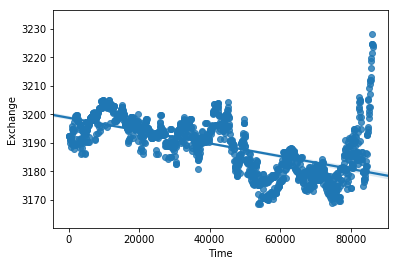

In [9]:
#Se calcula y grafica linea de tendencia. Se establece una escala "visual" de 24h en segundos.
time_exchange = np.arange(0,86400,(86400/len(crypto_ex2)))
time_ex_pandas = pd.DataFrame(time_exchange)
crypto_reg_ex = time_ex_pandas.join(crypto_ex2).rename(index=int, columns={0:"Time"})
#Cálculo de la línea de tendencia
z = np.polyfit(time_exchange, crypto_ex2['Exchange'], 1)
p = np.poly1d(z)
print("y=%.6fx+(%.6f)"%(z[0],z[1]),'\n')
#Gráfico
sns.regplot(x="Time", y="Exchange", data=crypto_reg_ex)

### Web Scraping

In [20]:
#Extracción de datos del HTML DOM. Se hace un loop por cada página del url.
url_pattern = 'https://localbitcoins.com/es/buy-bitcoins-online/eur/?page=%s'
n = 10
scrap = []
for p in range(1,n+1):
    scrap_localInfo = []
    localInfo = requests.get(url_pattern%p)
#Uso del módulo BeautifulSoup.
    soup = BeautifulSoup(localInfo.text, 'html.parser')
    for a in soup.find_all('td', class_="column-price"):
        scrap_localInfo.append(a.get_text('column-price'))
#Loop para eliminar caracteres indeseados.
    for i in range(len(scrap_localInfo)):
        scrap_localInfo[i] = re.sub('\s','',scrap_localInfo[i]).replace('EUR', '').replace(',','')
#Loop para transformar los valores a tipo float.
    for e in range(len(scrap_localInfo)):
        scrap_localInfo[e] = float(scrap_localInfo[e])
    scrap.append(scrap_localInfo)
#Se incluyen todos los valores en una única lista.
local = [e for x in scrap for e in x]
#Se transforma la lista en DataFrame (equivalente a 'crypto_ex2')
crypto_local = pd.DataFrame(local).rename(index=int, columns={0:"Permutas"})
display(crypto_local.dtypes,crypto_local.head(),len(crypto_local))
#NOTA: el valor en el index=0 es el valor más reciente en el tiempo.

Permutas    float64
dtype: object

,Permutas
0,3218.12
1,3223.88
2,3236.54
3,3248.68
4,3248.99


250

In [21]:
#Se guarda fichero .csv en output con los datos "en bruto".
crypto_local.to_csv('./output/crypto_local.csv', index=False, encoding = 'utf-8')

In [22]:
#Se generan valores estadisticos del nuevo DataFrame.
stats_loc = crypto_local.describe().transpose()
stats_loc['IQR'] = stats_loc['75%'] - stats_loc['25%']
display(stats_loc)

,count,mean,std,min,25%,50%,75%,max,IQR
Permutas,250.0,3579.32744,212.526946,3218.12,3405.96,3522.995,3761.69,3986.75,355.73


In [23]:
#Se calcula el porcentaje de outliers.
out_loc = pd.DataFrame(columns=crypto_local.columns)
for col in stats_loc.index:
    iqr = stats_loc.at[col,'IQR']
    cutoff = iqr * 1.5
    lower = stats_loc.at[col,'25%'] - cutoff
    upper = stats_loc.at[col,'75%'] + cutoff
    results = crypto_local[(crypto_local[col] < lower) | 
                   (crypto_local[col] > upper)].copy()
    out_loc = out_loc.append(results)
print('El porcentaje de outliers es de:',"{0:.2f}".format(len(out_loc)/len(crypto_ex2)*100),'%')

El porcentaje de outliers es de: 0.00 %


y=0.008445x+(3215.972549) 



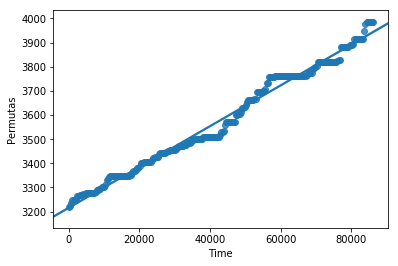

In [24]:
#Se calcula y grafica linea de tendencia. Se establece una escala "visual" de 24h en segundos.
time_local = np.arange(0,86400,(86400/len(crypto_local)))
time_loc_pandas = pd.DataFrame(time_local)
crypto_reg_loc = time_loc_pandas.join(crypto_local).rename(index=int, columns={0:"Time"})
#Cálculo de la línea de tendencia
z = np.polyfit(time_local, crypto_local['Permutas'], 1)
p = np.poly1d(z)
print("y=%.6fx+(%.6f)"%(z[0],z[1]),'\n')
#Gráfico
sns.regplot(x="Time", y="Permutas", data=crypto_reg_loc)

### CONCLUSIONES DEL USO DE LAS HERRAMIENTAS API REST Y WEB SCRAPING
La API REST seleccionada ha sido bastante cómoda aunque no fue la primera opción. La primera opción fue la API de Binance que si que era más compleja ya que este Exchange es de los más grandes del mundo y maneja cientos de AltCoins, mientras que Bitstamp solo maneja 5. No obstante, se optó por usar Bitstamp tanto por su mayor facilidad de uso y simpleza en los parámetros como por aportar los datos en EUR directamente lo que ahorra el paso de trasladar los valores de USD a EUR.
En cuanto al WEB SCRAPING, fue necesario realizar varios loops hasta obtener datos con los que se pudiese trabajar. Asimismo, se detectó que se extraían valores "fantasmas" tras superar el número de páginas listadas. No obstante, se ha optado por no corregir este error ya que se ha observado que las ofertas hacia las páginas finales suelen ser ofertas "marginales" (el problema se podría resolver estableciendo una condición de 'break' justo después del loop donde se aplica la función de Beautiful Soup, poniendo una condición de parar si no se obtienen menos de 50 registros).
La relación entre los datos de las dos fuentes se ha realizado tanto haciendo ciertas consideraciones (un tanto alegres) en el eje temporal como con análisis estadísticos.

### CONCLUSIONES DEL ANÁLISIS DE LOS DATOS
Se ha detectado una desviación importante entre la tendencia de los datos de trading y las permutas P2P (e.g.: la pendiente de la línea de tendencia de los valores de trading es ligeramente negativa mientras que en el caso de los valores P2P es ligeramente positiva). Las posibles causas de dicha desviación son:
- Excesivas simplificaciones en el análisis estadístico (en particular en el eje de las abscisas, i.e.: tiempo).
- Fuerte lateralización del mercado de las criptomonedas.
- Aunmento de la crisis financiera en los países de mayor uso de la plataforma P2P lo que lleva a mayor epeculación.
Sin embargo, una posible aplicación del lógica planteada en este proyecto sería el establecimiento de recomendadores de transacciones en base tanto a precio como posición en el listado de ofertas en las permutas (i.e.: el programa podría arrojar el número límite de ofertas -precio- a tener en consideración a la hora de hacer transacciones P2P, ya que se puede detectar como el IQR aumenta según se aumenta el número de páginas "scrapeadas"). Asimismo, también sería posible detectar manipulaciones en el mercado de trading en épocas de alta volatilidad.